In [0]:
import json
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import sgd

Using TensorFlow backend.


In [0]:
class Catch(object):
  def __init__(self, grid_size=10):
    self.grid_size = grid_size
    self.reset()

  def _update_state(self, action):
    """
    Input: action and states
    Ouput: new states and reward
    """
    state = self.state
    if action == 0:  # left
      action = -1
    elif action == 1:  # stay
      action = 0
    else:
      action = 1  # right
    f0, f1, basket = state[0]
    new_basket = min(max(1, basket + action), self.grid_size-1)
    f0 += 1
    out = np.asarray([f0, f1, new_basket])
    out = out[np.newaxis]

    assert len(out.shape) == 2
    self.state = out

  def _draw_state(self):
    im_size = (self.grid_size,)*2
    state = self.state[0]
    canvas = np.zeros(im_size)
    canvas[state[0], state[1]] = 1  # draw fruit
    canvas[-1, state[2]-1:state[2] + 2] = 1  # draw basket
    return canvas

  def _get_reward(self):
    fruit_row, fruit_col, basket = self.state[0]
    if fruit_row == self.grid_size-1:
      if abs(fruit_col - basket) <= 1:
        return 1
      else:
        return -1
    else:
      return 0

  def _is_over(self):
    if self.state[0, 0] == self.grid_size-1:
      return True
    else:
      return False

  def observe(self):
    canvas = self._draw_state()
    return canvas.reshape((1, -1))

  def act(self, action):
    self._update_state(action)
    reward = self._get_reward()
    game_over = self._is_over()
    return self.observe(), reward, game_over

  def reset(self):
    n = np.random.randint(0, self.grid_size-1, size=1)
    m = np.random.randint(1, self.grid_size-2, size=1)
    self.state = np.asarray([0, n[0], m[0]])[np.newaxis]

In [0]:
class ExperienceReplay(object):
  def __init__(self, max_memory=100, discount=.9):
    self.max_memory = max_memory
    self.memory = list()
    self.discount = discount

  def remember(self, states, game_over):
    # memory[i] = [[state_t, action_t, reward_t, state_t+1], game_over?]
    self.memory.append([states, game_over])
    if len(self.memory) > self.max_memory:
      del self.memory[0]

  def get_batch(self, model, batch_size=10):
    len_memory = len(self.memory)
    num_actions = model.output_shape[-1]
    env_dim = self.memory[0][0][0].shape[1]
    inputs = np.zeros((min(len_memory, batch_size), env_dim))
    targets = np.zeros((inputs.shape[0], num_actions))
    for i, idx in enumerate(np.random.randint(0, len_memory,
                                              size=inputs.shape[0])):
      state_t, action_t, reward_t, state_tp1 = self.memory[idx][0]
      game_over = self.memory[idx][1]

      inputs[i] = state_t
        # There should be no target values for actions not taken.
        # Thou shalt not correct actions not taken #deep
      targets[i] = model.predict(state_t)[0]
      Q_sa = np.max(model.predict(state_tp1)[0])
      if game_over:  # if game_over is True
        targets[i, action_t] = reward_t
      else:
        # reward_t + gamma * max_a' Q(s', a')
        targets[i, action_t] = reward_t + self.discount * Q_sa
    return inputs, targets

In [0]:
epsilon = .1  # exploration
num_actions = 3  # [move_left, stay, move_right]
epoch = 1000
max_memory = 500
hidden_size = 100
batch_size = 50
grid_size = 10

model = Sequential()
model.add(Dense(hidden_size, input_shape=(grid_size**2,), activation='relu'))
model.add(Dense(hidden_size, activation='relu'))
model.add(Dense(num_actions))
model.compile(sgd(lr=.2), "mse")

# If you want to continue training from a previous model, just uncomment the line bellow
# model.load_weights("model.h5")

# Define environment/game
env = Catch(grid_size)

# Initialize experience replay object
exp_replay = ExperienceReplay(max_memory=max_memory)

# Train
win_cnt = 0
for e in range(epoch):
  loss = 0.
  env.reset()
  game_over = False
  # get initial input
  input_t = env.observe()

  while not game_over:
    input_tm1 = input_t
    # get next action
    if np.random.rand() <= epsilon:
      action = np.random.randint(0, num_actions, size=1)
    else:
      q = model.predict(input_tm1)
      action = np.argmax(q[0])

            # apply action, get rewards and new state
    input_t, reward, game_over = env.act(action)
    if reward == 1:
      win_cnt += 1

    # store experience
    exp_replay.remember([input_tm1, action, reward, input_t], game_over)

    # adapt model
    inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)

    loss += model.train_on_batch(inputs, targets)
  print("Epoch {:03d}/999 | Loss {:.4f} | Win count {}".format(e, loss, win_cnt))

    # Save trained model weights and architecture, this will be used by the visualization code
model.save_weights("model.h5", overwrite=True)
with open("model.json", "w") as outfile:
  json.dump(model.to_json(), outfile)

Epoch 000/999 | Loss 0.1120 | Win count 0
Epoch 001/999 | Loss 0.1539 | Win count 1
Epoch 002/999 | Loss 0.1637 | Win count 2
Epoch 003/999 | Loss 0.1585 | Win count 2
Epoch 004/999 | Loss 0.2214 | Win count 2
Epoch 005/999 | Loss 0.3079 | Win count 2
Epoch 006/999 | Loss 0.2406 | Win count 2
Epoch 007/999 | Loss 0.1916 | Win count 2
Epoch 008/999 | Loss 0.2496 | Win count 2
Epoch 009/999 | Loss 0.2067 | Win count 2
Epoch 010/999 | Loss 0.1830 | Win count 3
Epoch 011/999 | Loss 0.2517 | Win count 4
Epoch 012/999 | Loss 0.2051 | Win count 5
Epoch 013/999 | Loss 0.2474 | Win count 6
Epoch 014/999 | Loss 0.2734 | Win count 6
Epoch 015/999 | Loss 0.2480 | Win count 6
Epoch 016/999 | Loss 0.2759 | Win count 6
Epoch 017/999 | Loss 0.2195 | Win count 6
Epoch 018/999 | Loss 0.2187 | Win count 7
Epoch 019/999 | Loss 0.2549 | Win count 7
Epoch 020/999 | Loss 0.2245 | Win count 7
Epoch 021/999 | Loss 0.2244 | Win count 7
Epoch 022/999 | Loss 0.1824 | Win count 8
Epoch 023/999 | Loss 0.1890 | Win 

In [0]:
from keras.models import model_from_json
import matplotlib.pyplot as plt

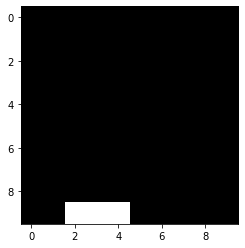

In [0]:
# Make sure this grid size matches the value used fro training
grid_size = 10

with open("model.json", "r") as jfile:
  model = model_from_json(json.load(jfile))
model.load_weights("model.h5")
model.compile("sgd", "mse")

# Define environment, game
env = Catch(grid_size)
c = 0
for e in range(10):
  loss = 0.
  env.reset()
  game_over = False
  # get initial input
  input_t = env.observe()

  plt.imshow(input_t.reshape((grid_size,)*2),
              interpolation='none', cmap='gray')
  plt.savefig("%03d.png" % c)
  c += 1
  while not game_over:
    input_tm1 = input_t

    # get next action
    q = model.predict(input_tm1)
    action = np.argmax(q[0])

    # apply action, get rewards and new state
    input_t, reward, game_over = env.act(action)

    plt.imshow(input_t.reshape((grid_size,)*2),
                interpolation='none', cmap='gray')
    plt.savefig("%03d.png" % c)
    c += 1

In [0]:
sorted(glob.glob("*.png"))

In [0]:
from PIL import Image
import glob

# Create the frames
frames = []
imgs = sorted(glob.glob("*.png"))
for i in imgs:
  new_frame = Image.open(i)
  frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save('png_to_gif.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=150, loop=0) #duration is display duration of each frame